In [1]:
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class DensityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(1, 8, 1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 8, 1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 1, 1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, N = x.shape
        x = x.unsqueeze(1)
        density_scale = self.mlp(x)
        return density_scale.squeeze(1)

In [3]:
import torch
from gpytorch.kernels import RBFKernel
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

k = RBFKernel()
k.lengthscale = 0.1

def true_function(x):
    return torch.sin(3 * x) + 3 * x ** 2 - 2 * x ** 3 - torch.cos(- 10 * x)

In [4]:
xc = torch.empty(10, 1).uniform_(-2, 2)
yc = true_function(xc)
xt = torch.empty(20, 1).uniform_(-2, 2)
yt = true_function(xt)
x = torch.linspace(-2, 2, 100).unsqueeze(-1)

with torch.no_grad():
    dc = k(x, xc).evaluate().mean(-1)
    dt = k(x, xt).evaluate().mean(-1)
    dm = k(x, torch.cat([xc, xt], 0)).evaluate().mean(-1)
    density = DensityNet()(dm.unsqueeze(0))

In [5]:
(xc - xc.mean()).pow(2).sum() / (xc.size(0) - 1)

tensor(1.4607)

In [6]:
np.cov(xc.numpy().reshape(1, -1))

array(1.46072046)

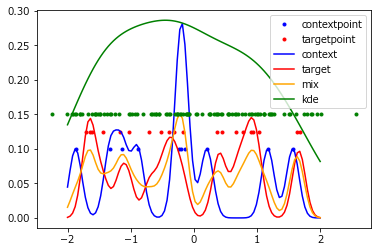

In [8]:
plt.plot(xc, torch.ones_like(xc)*0.1, '.', color='blue', label='contextpoint')
plt.plot(xt, torch.ones_like(xt)*0.125, '.', color='red', label='targetpoint')
plt.plot(x, dc, label='context', color='blue')
plt.plot(x, dt, label='target', color='red')
plt.plot(x, dm, label='mix', color='orange')

kde = gaussian_kde(torch.cat([xc, xt], 0).numpy().transpose())
# kde = gaussian_kde(xc.numpy().transpose())
plt.plot(x.numpy(), kde(x.numpy().transpose()), label='kde', color='green')
s = torch.from_numpy(kde.resample(size=100))
plt.plot(s, torch.ones_like(s)*0.15, '.', color='green')
plt.legend()


In [6]:
from numpy.random import multivariate_normal

In [7]:
np.transpose(multivariate_normal(np.zeros((1,)), np.ones((1,1)), size=5)).shape

(1, 5)

In [8]:
with torch.no_grad():
    cov = k(xt.T, xt.T).evaluate()

In [9]:
torch.from_numpy(np.cov(xc.T.numpy())).float()

tensor(1.0710)

In [10]:
xc = torch.empty(3, 10, 1).uniform_(-2, 2)


In [11]:
gaussian_kde(xc.permute(0, 2, 1).numpy())

ValueError: too many values to unpack (expected 2)

In [1]:
import numpy as np
import warnings
import torch
import h5py
from torch.utils.data import Dataset
warnings.filterwarnings('ignore')

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    print(f.keys())
    data = f['data'][:]
    label = f['label'][:]
    seg = f['normal'][:]
    return (data, label, seg)

def load_data(dir,classification = False):
    data_train0, label_train0,Seglabel_train0  = load_h5(dir + 'ply_data_train0.h5')
    data_train1, label_train1,Seglabel_train1 = load_h5(dir + 'ply_data_train1.h5')
    data_train2, label_train2,Seglabel_train2 = load_h5(dir + 'ply_data_train2.h5')
    data_train3, label_train3,Seglabel_train3 = load_h5(dir + 'ply_data_train3.h5')
    data_train4, label_train4,Seglabel_train4 = load_h5(dir + 'ply_data_train4.h5')
    data_test0, label_test0,Seglabel_test0 = load_h5(dir + 'ply_data_test0.h5')
    data_test1, label_test1,Seglabel_test1 = load_h5(dir + 'ply_data_test1.h5')
    train_data = np.concatenate([data_train0,data_train1,data_train2,data_train3,data_train4])
    train_label = np.concatenate([label_train0,label_train1,label_train2,label_train3,label_train4])
    train_Seglabel = np.concatenate([Seglabel_train0,Seglabel_train1,Seglabel_train2,Seglabel_train3,Seglabel_train4])
    test_data = np.concatenate([data_test0,data_test1])
    test_label = np.concatenate([label_test0,label_test1])
    test_Seglabel = np.concatenate([Seglabel_test0,Seglabel_test1])

    if classification:
        return train_data, train_label, test_data, test_label
    else:
        return train_data, train_Seglabel, test_data, test_Seglabel

class ModelNetDataLoader(Dataset):
    def __init__(self, data, labels, rotation = None):
        self.data = data
        self.labels = labels
        self.rotation = rotation

    def __len__(self):
        return len(self.data)

    def rotate_point_cloud_by_angle(self, data, rotation_angle):
        """
        Rotate the point cloud along up direction with certain angle.
        :param batch_data: Nx3 array, original batch of point clouds
        :param rotation_angle: range of rotation
        :return:  Nx3 array, rotated batch of point clouds
        """
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]], dtype = np.float32)
        rotated_data = np.dot(data, rotation_matrix)

        return rotated_data

    def __getitem__(self, index):
        if self.rotation is not None:
            pointcloud = self.data[index]
            angle = np.random.randint(self.rotation[0], self.rotation[1]) * np.pi / 180
            pointcloud = self.rotate_point_cloud_by_angle(pointcloud, angle)

            return pointcloud, self.labels[index]
        else:
            return self.data[index], self.labels[index]

In [2]:
datapath = '/Users/makora/data/modelnet40/modelnet40_ply_hdf5_2048/'
train_data, train_label, test_data, test_label = load_data(datapath, classification=False)

<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>
<KeysViewHDF5 ['data', 'faceId', 'label', 'normal']>


In [3]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((9840, 2048, 3), (9840, 2048, 3), (2468, 2048, 3), (2468, 2048, 3))

In [8]:
train_label[0][:10]

array([[ 0.,  0.,  1.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0., -1.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]], dtype=float32)

In [9]:
import open3d as o3d
import open3d_tutorial as o3dtut
o3dtut.interactive = True

In [13]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(train_data[4])
pcd.colors = o3d.utility.Vector3dVector(np.ones(train_data[4].shape) * 0.5)

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(train_data[1101])

In [15]:
pcd_tmp = pcd2.voxel_down_sample(0.1)

In [16]:
pcd_tmp

geometry::PointCloud with 531 points.

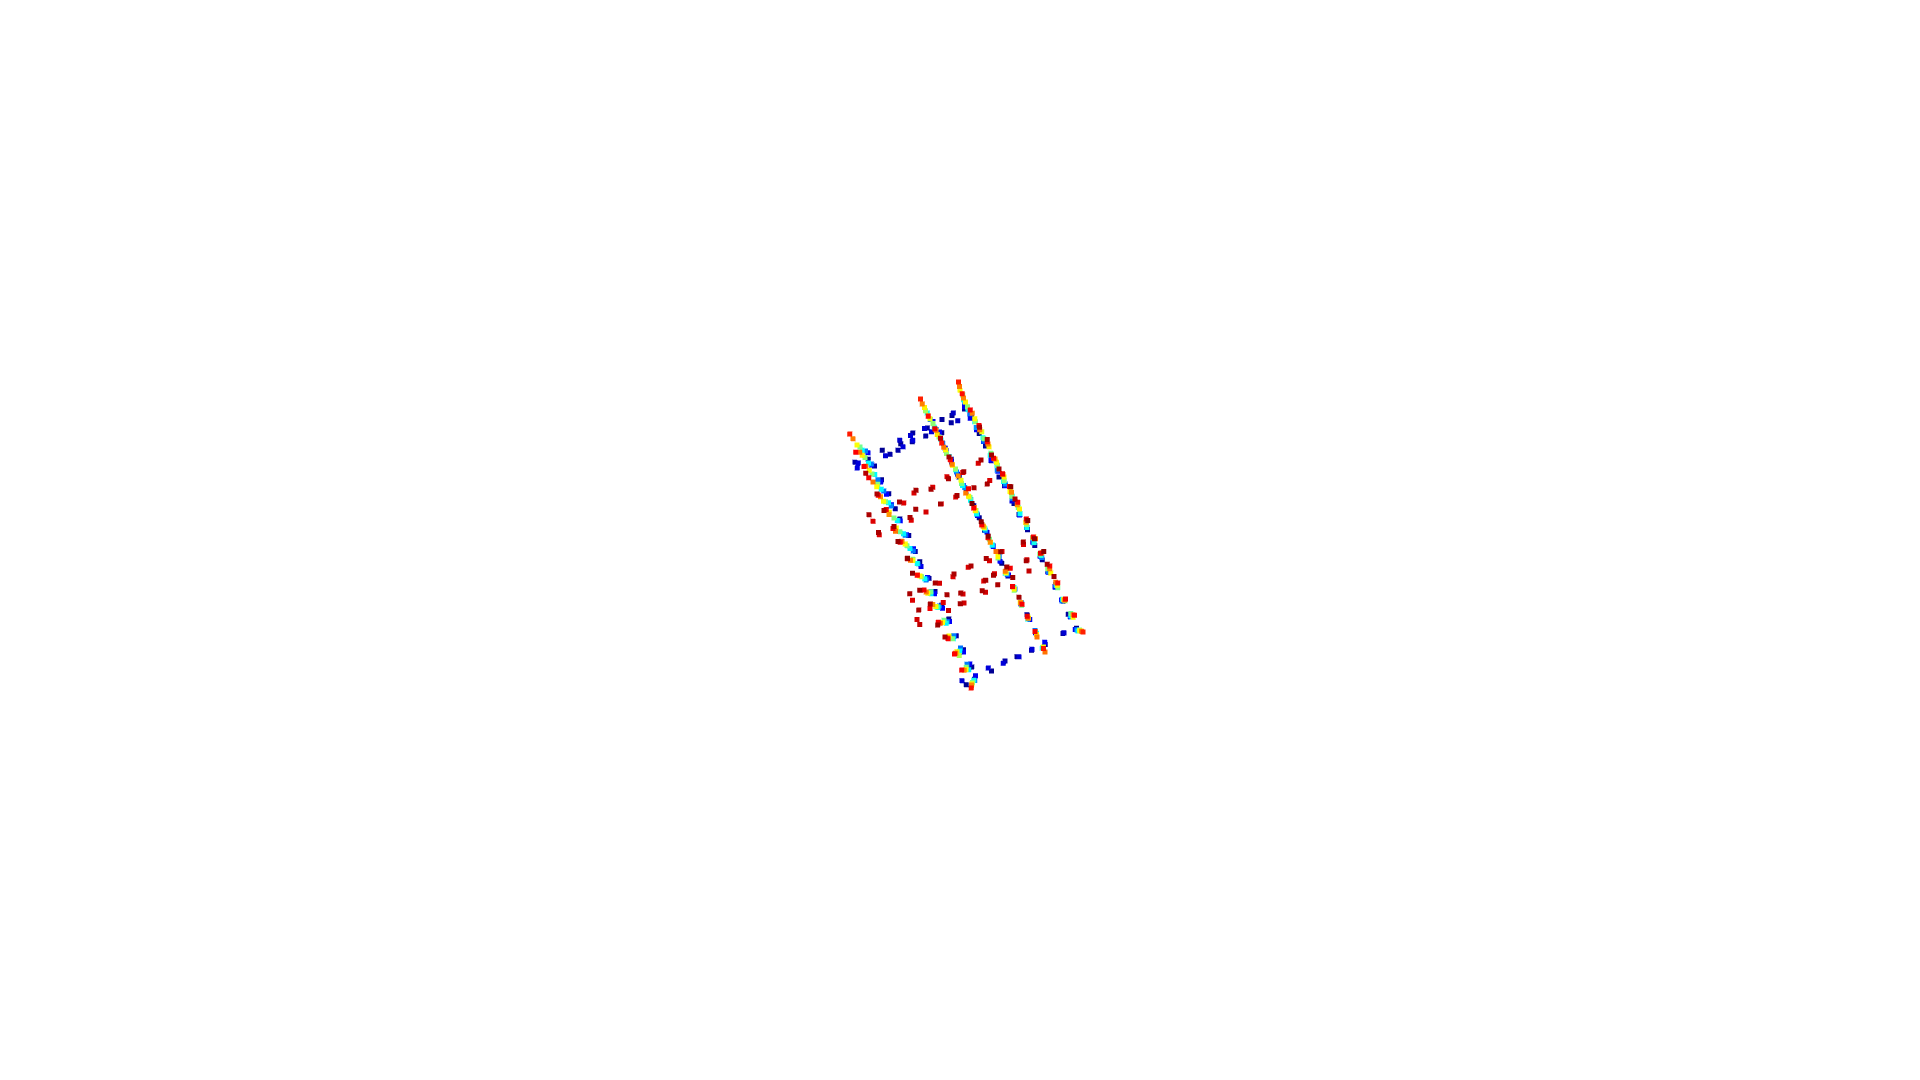

In [17]:
o3d.visualization.draw_geometries([pcd_tmp])

In [16]:
o3d.utility.Vector3dVector(train_data[4])

std::vector<Eigen::Vector3d> with 2048 elements.
Use numpy.asarray() to access data.

In [41]:
a = train_data[5]

In [46]:
a[:, 0].min(), a[:, 0].max(), a[:, 1].min(), a[:, 1].max(), a[:, 2].min(), a[:, 2].max()

(-0.9299141, 0.83642346, -0.45201114, 0.4810139, -0.84278226, 0.9392172)

In [47]:
2 ** 11

2048

In [48]:
2048 ** (1/3)

12.699208415745595

In [58]:
import numpy as np
arr = np.arange(4)

In [82]:
np.cov(arr)

array(1.66666667)

In [62]:
m = arr.mean()

In [81]:
(arr**2).mean() - (m**2)

1.25

In [86]:
np.average(arr.reshape(1, -1), axis=1, returned=True)

(array([1.5]), array([4.]))

In [89]:
X = arr.reshape(1, -1) - arr.mean()

In [97]:
np.dot(X, X.T.conj()) / 4

array([[1.25]])

In [91]:
X

array([[-1.5, -0.5,  0.5,  1.5]])

In [99]:
(X ** 2).sum() / 3

1.6666666666666667

In [341]:
import torch
x = torch.randn(16, 30, 1)
arr = torch.arange(4).float().reshape(1, -1, 1).repeat(4, 1, 1)

In [342]:
from lienp.modules.kde import GaussianKDE
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
k = RBFKernel()
k.lengthscale = 0.1
x=torch.linspace(-2, 2, 100).reshape(1, -1, 1)

In [343]:
xc = torch.empty(1, 10, 1).uniform_(-2, 2)
xt = torch.empty(1, 20, 1).uniform_(-2, 2)

# kde = GaussianKDE(xc)
kde = GaussianKDE(torch.cat([xc, xt], 1))

In [344]:
with torch.no_grad():
    dc = k(x, xc).evaluate().mean(-1)[0]
    dt = k(x, xt).evaluate().mean(-1)[0]
    dm = k(x, torch.cat([xc, xt], 1)).evaluate().mean(-1)[0]
    xk = kde.resample(100)
    
    dkc = k(xk, xc).evaluate().mean(-1)[0]
    dkt = k(xk, xt).evaluate().mean(-1)[0]

In [345]:
from scipy.stats import gaussian_kde
kkk = gaussian_kde(xc.reshape(1, -1).numpy())

(-2, 2)

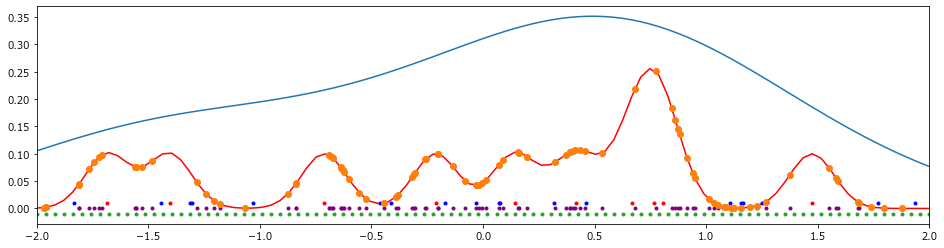

In [350]:
plt.figure(figsize=(16,4))
plt.plot(x.squeeze(), dc, color='red')
plt.plot(xc.squeeze(), torch.zeros(10)+0.01, '.', color='red')

# plt.plot(x.squeeze(), dt, color='blue')
plt.plot(xt.squeeze(), torch.zeros(xt.squeeze().shape)+0.01, '.', color='blue')

# plt.plot(x.squeeze(), dm, color='green')

plt.plot(x.squeeze().numpy(), kkk(x.squeeze().numpy()))
plt.plot(xk.squeeze(), torch.zeros_like(xk.squeeze()), '.', color='purple')

plt.plot(xk.squeeze(), dkc, 'o')
# plt.plot(xk.squeeze(), dkt, 'o')

plt.plot(torch.linspace(-2, 2, 100), torch.zeros(100) - 0.01, '.')
plt.xlim(-2, 2)

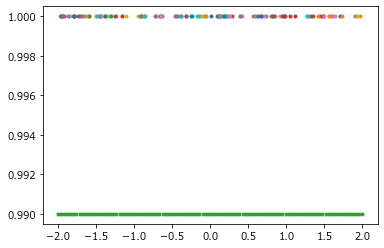

In [298]:
plt.plot(torch.cat([xc, xt], -2).squeeze(), torch.ones_like(torch.cat([xc, xt], -2).squeeze()), '.')
plt.plot(torch.linspace(-2, 2, 100), torch.ones(100)-0.01, '.')

In [358]:
xc = torch.empty(3, torch.randint(0, 5, (1,)).item(), 1).uniform_(-2, 2)
xt = torch.empty(3, 10, 1).uniform_(-2, 2)
xx = torch.cat([xc, xt], -2)
tt = torch.linspace(-2, 2, 100).reshape(1, -1, 1).repeat(3, 1, 1)

In [359]:
kidx = torch.topk(torch.norm(xx.unsqueeze(-2) - tt.unsqueeze(-3), dim=-1), 100//xx.size(1), largest=False)[1]

In [360]:
ttt = torch.unique(tt[torch.arange(3).reshape(-1, 1, 1), kidx].reshape(3, -1, 1), dim=1)

In [361]:
ttt.shape

torch.Size([3, 98, 1])

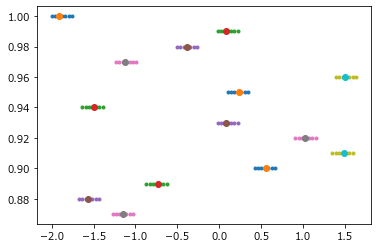

In [362]:
# plt.figure(figsize=(16, 12))
for i in range(xc.size(1)+xt.size(1)):
    plt.plot(tt[0, kidx[0]][i], torch.ones(100//xx.size(1))-0.01*i, '.')
    plt.plot(xx[0, i], torch.ones(1) - 0.01 *i, 'o')


torch.Size([100, 1])


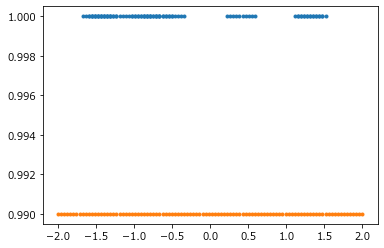

In [340]:
plt.plot(ttt[1], torch.ones(ttt[0].shape), '.' )
plt.plot(tt[1], torch.ones(100) - 0.01, '.' )
print(ttt[1].shape)

In [250]:
xc = torch.randint(0, 28, (20, 2)).float()
xt = torch.randint(0, 28, (30, 2)).float()
xx = torch.cat([xc, xt], 0)
tt = torch.stack(torch.meshgrid(torch.arange(28), torch.arange(28)), -1).reshape(-1, 2).float()

In [251]:
kidx = torch.topk(torch.norm(xx.unsqueeze(-2) - tt.unsqueeze(-3), dim=-1), 748//50, largest=False, dim=1)[1]

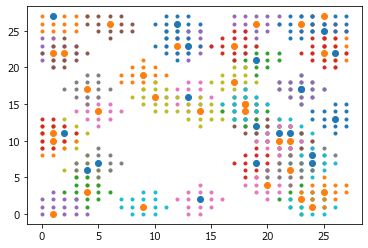

In [252]:
for j in tt[kidx]:
    plt.plot(j[:, 0], j[:, 1], '.')
# plt.plot(tt[:, 0], tt[:, 1], '.')
plt.plot(xc[:, 0], xc[:, 1], 'o')
plt.plot(xt[:, 0], xt[:, 1], 'o')

In [262]:
hoge = torch.unique(tt[kidx].reshape(-1, 2), dim=1)

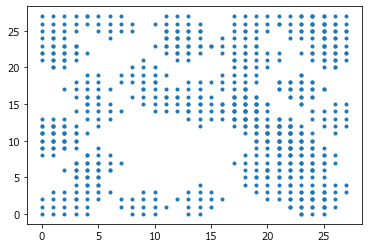

In [263]:
plt.plot(hoge[:, 0], hoge[:, 1], '.')

In [273]:
hoge[:, 1][hoge[:, 0] == 0]

tensor([27., 26., 25., 11., 10., 11.,  9., 12.,  8., 11., 12., 10.,  9., 13.,
        22., 23., 21., 24.,  0.,  1.,  2., 22.])